# Machine Learning - Practical 4 - Deep Learning VS Trees


Names:  Rana Ashar Mehmood - Ahsan Ali - Muhammad Talha Abbas
Summer Term 2023
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


## Download the dataset from this link https://drive.google.com/file/d/1no2rt94YyQ-UXwt0yhbBrfhbUqER0HmN/view?usp=sharing

In [39]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [40]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**

Remove all rows containing at least one missing entry.

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**

Remove categorical features with more than 20 items.

**High cardinality numerical features**

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [41]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [42]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/content/gdrive/MyDrive/ML4file/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [43]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [44]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [45]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans
    '''
    # TODO
    df.dropna(inplace= True)
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical
    if it has <= n unique values
    '''
    # TODO
    for column in df.columns:
        if column not in ignore and df[column].nunique() <= n:
            df[column] = df[column].astype('category')

    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less',
                        ignore=[target_column]):
    '''
    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''

    filtered_columns = []
    for column in df.columns:
        if column in ignore:
            continue
        if df[column].dtype == condition:
          if direction == 'less' and df[column].nunique() < n:
              filtered_columns.append(column)
          elif direction == 'more' and df[column].nunique() > n:
              filtered_columns.append(column)

    df_filtered = df.drop(columns=filtered_columns)
    return df_filtered


In [46]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less',
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more',
                         ignore=[target_column])

assert not df.isna().any().any(), 'There are still nans in the dataframe'

<ipython-input-45-3c72bd25f13c>:35: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype == condition:


In [47]:
df

,Vehicle_Reference_df_res,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,...,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Casualty_Type,Casualty_IMD_Decile
2,1,9.0,9.0,0.0,0.0,0.0,1.0,1.0,30.0,6.0,...,1,3,2.0,33.0,6.0,3,1.0,3.0,0,6.0
6,1,3.0,18.0,0.0,0.0,0.0,1.0,1.0,37.0,7.0,...,1,1,1.0,37.0,7.0,3,0.0,0.0,3,5.0
7,2,19.0,6.0,0.0,0.0,0.0,1.0,1.0,44.0,7.0,...,1,1,1.0,37.0,7.0,3,0.0,0.0,3,5.0
8,1,9.0,9.0,0.0,0.0,0.0,1.0,1.0,37.0,7.0,...,1,1,1.0,37.0,7.0,3,0.0,0.0,1,8.0
12,1,9.0,13.0,0.0,0.0,0.0,1.0,2.0,39.0,7.0,...,1,1,1.0,61.0,9.0,3,0.0,0.0,5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328127,1,9.0,5.0,0.0,0.0,0.0,1.0,2.0,75.0,10.0,...,2,1,2.0,43.0,7.0,3,0.0,0.0,9,6.0
328128,2,9.0,18.0,0.0,0.0,0.0,1.0,1.0,18.0,4.0,...,1,1,1.0,18.0,4.0,3,0.0,0.0,9,10.0
328129,2,9.0,18.0,0.0,0.0,0.0,1.0,1.0,18.0,4.0,...,2,1,2.0,43.0,7.0,3,0.0,0.0,9,6.0
328130,3,9.0,3.0,0.0,0.0,0.0,1.0,2.0,43.0,7.0,...,1,1,1.0,18.0,4.0,3,0.0,0.0,9,10.0


In [48]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(columns=[target_column])
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2)

**TODO :**

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable?


1.   Yes, the dataset is split in a stratified manner to preserve the class distribution of the target variable. This is important because the target variable exhibits significant differences in values across its classes. The value counts for each class in the target variable are as follows: 63072 samples for class 1, 33101 samples for class 2, and 154 samples for class 3.
2.   Initially dimentions of dataset were 363243 rows × 67 columns and after pre-processing dimentions are 96326 rows × 33 columns.
3. There are 3 unique values in response variable.



## Task 1: Create a GradientBoostingClassifier

In [49]:
## TODO : define the GradientBoostingClassifier,
## train it on the train set and predict on the test set

model = GradientBoostingClassifier()
model.fit(train_X, train_y)
predictions = model.predict(test_X)


In [50]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

accuracy = accuracy_score(test_y, predictions)
precision = precision_score(test_y, predictions, average='weighted')
recall = recall_score(test_y, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.7911346413370705
Precision: 0.7864725722759981
Recall: 0.7911346413370705


In [13]:
## TODO : Write a function which iterates over trees_amount,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
    for n_trees in trees_amount:

        model = GradientBoostingClassifier(n_estimators=n_trees)
        model.fit(train_X, train_y)

        predictions = model.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the results
        print(f"Number of trees: {n_trees}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("====================")



In [14]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of trees: 1
Accuracy: 0.6573756877400602
Precision: 0.432255909292117
Recall: 0.6573756877400602
Number of trees: 20
Accuracy: 0.771255060728745
Precision: 0.7661583735676147
Recall: 0.771255060728745
Number of trees: 50
Accuracy: 0.7788850825288072
Precision: 0.7728276765221942
Recall: 0.7788850825288072
Number of trees: 100
Accuracy: 0.7881241565452092
Precision: 0.7829426618156926
Recall: 0.7881241565452092


In [15]:
## TODO : Write a function which iterates over the learning rate,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
    for lr in learning_rates:
        model = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=lr)
        model.fit(train_X, train_y)
        predictions = model.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"Learning Rate: {lr}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)

In [16]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1
Accuracy: 0.7880203467248001
Precision: 0.7828910713909347
Recall: 0.7880203467248001
Learning Rate: 0.2
Accuracy: 0.7925879788227966
Precision: 0.7881124199545269
Recall: 0.7925879788227966
Learning Rate: 0.3
Accuracy: 0.7958579881656804
Precision: 0.7914390561572855
Recall: 0.7958579881656804
Learning Rate: 0.4
Accuracy: 0.7976227551126337
Precision: 0.792536922977536
Recall: 0.7976227551126337
Learning Rate: 0.5
Accuracy: 0.7937298868472957
Precision: 0.7896331371740676
Recall: 0.7937298868472957


In [17]:
## TODO : Write a function which iterates over different depths,
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1, 2, 3, 5], trees_amount=50):
    for depth in depths:
        model = GradientBoostingClassifier(max_depth=depth, n_estimators=trees_amount)
        model.fit(train_X, train_y)
        predictions = model.predict(test_X)

        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"Max Depth: {depth}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)



In [18]:
max_depth_exploration(train_X, train_y, test_X, test_y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Max Depth: 1
Accuracy: 0.7465483234714004
Precision: 0.7369399384457502
Recall: 0.7465483234714004
Max Depth: 2
Accuracy: 0.7636769438388872
Precision: 0.7563895093942788
Recall: 0.7636769438388872
Max Depth: 3
Accuracy: 0.7788850825288072
Precision: 0.7728645805178492
Recall: 0.7788850825288072
Max Depth: 5
Accuracy: 0.7943527457697498
Precision: 0.7901646824807883
Recall: 0.7943527457697498


**TODO :**

* How does the max_depth parameter influence the results?
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

The max_depth parameter in gradient boosting algorithms controls the maximum depth of each decision tree in the ensemble. Increasing the max_depth can result in a more complex model that can capture intricate patterns in the data. However, setting a larger max_depth can also lead to overfitting, especially if the dataset is small or noisy. On the other hand, using a smaller max_depth can help prevent overfitting but may result in a less expressive model that may struggle to capture complex relationships.

The learning_rate parameter determines the contribution of each tree to the overall model. A smaller learning rate means that each tree's contribution is reduced, and the model learns more slowly. However, a smaller learning rate can also help in reaching a better solution by allowing the model to make smaller updates and avoid overshooting the optimal solution

The number of trees in the ensemble, specified by the n_estimators parameter, influences the overall complexity of the model. Increasing the number of trees allows the model to learn more complex relationships and potentially improve performance. However, there is a trade-off with computational efficiency, as a larger number of trees requires more computational resources and training time.


Our best model [n_estimators=100, lr=0.3, depth=5] gives an accuracy of 0.81.

In [51]:
tree = 100
lr = 0.3
depth = 5
classifier = GradientBoostingClassifier(n_estimators=tree, learning_rate= lr, max_depth=depth)
classifier.fit(train_X, train_y)
y_pred = classifier.predict(test_X)
acc = accuracy_score(test_y, y_pred)
prec = precision_score(test_y, y_pred,average = "macro")
rec = recall_score(test_y, y_pred,average = "macro")
print(f"For {tree} trees, Learning Rate: {lr}, Depth: {depth}, we have Accuracy = {acc}, Precision = {prec}, Recall = {rec}")

For Tree amount: 100, Learning Rate: 0.3, Depth: 5 => Accuracy = 0.8111699366760096, Precision = 0.6161312205221559, Recall = 0.560527590494901


In [19]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # TODO
    importances = clf.feature_importances_

    sorted_indices = importances.argsort()[::-1]

    sorted_feature_names = X.columns[sorted_indices]

    sorted_importances = importances[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Relative Importance')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

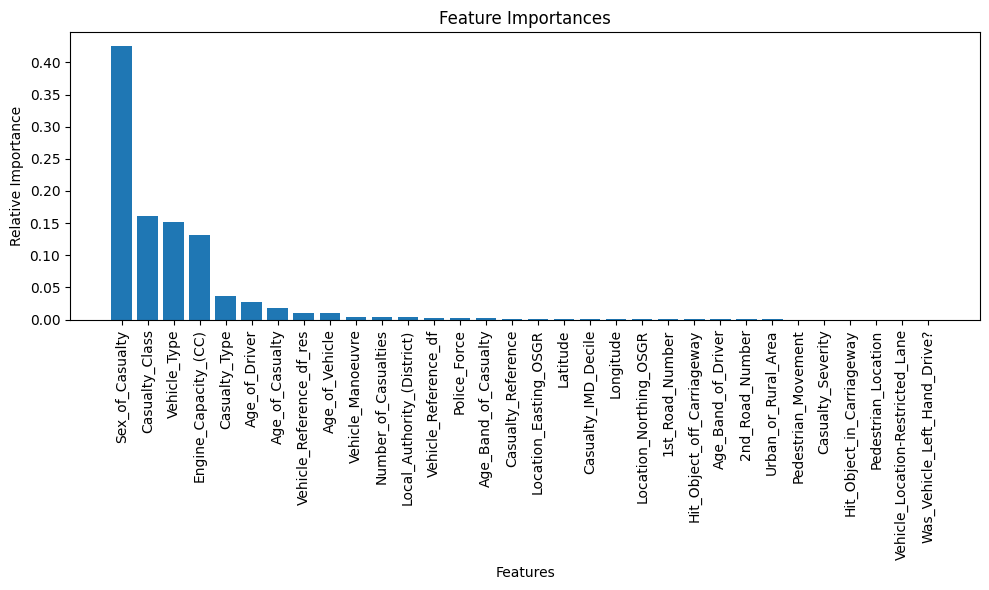

In [20]:
## TODO : display the plot
plot_explained_variance(model, X)

**TODO :** Interpret the plot.
By analyzing, we can determine the key factors that strongly influence the classifier's predictions. Features that possess greater importance (such as Sex_of_Casualty, Casualty_Class, Vehicle_Type, Engine_Capacity_(CC)) are regarded as more significant, while features with lower importance (like Was_Vehicle_Left_Hand_Drive?, Casualty_Severity, Pedestrian_Movement, Urban_or_Rural_Area, etc.) seem to have less relevance for the model in question.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why?

## Prepare for deep learning
### Add all the necessary training functions
*You can reuse them from previous practical exercises*

In [21]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct / total

In [22]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    # Todo
    _losses = []
    _accuracies = []

    model.train()

    for _, (x, y) in enumerate(master_bar):
        optimizer.zero_grad()

        # Forward pass: get predictions
        y_pred = model(x.to(device))

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        _losses.append(loss.cpu().item())

        _accuracies.append(accuracy(torch.sum(torch.argmax(y_pred, 1) == y.to(device)).item(), len(y_pred)))

        optimizer.step()

    return (np.mean(_losses), np.mean(_accuracies))

def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # Todo
    _losses = []
    _accuracies = []

    model.eval()

    with torch.no_grad():

        for _, (x, y) in enumerate(master_bar):
            # Forward pass: get predictions
            y_pred = model(x.to(device))

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            _accuracies.append(accuracy(torch.sum(torch.argmax(y_pred, 1) == y.to(device)).item(), len(y_pred)))

            _losses.append(loss.cpu().item())

    return (np.mean(_losses), np.mean(_accuracies))

In [23]:
#TODO write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3
from tqdm import trange,tqdm


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        with tqdm(train_dataloader, unit="batch") as tepoch:
            tepoch.set_description(f"Training Epoch {epoch+1}")
            train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, tepoch)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
        with tqdm(val_dataloader, unit="batch") as vepoch:
            vepoch.set_description(f"Validation Epoch {epoch+1}")
            val_loss, val_acc = validate(val_dataloader, model, loss_function, device,vepoch)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

    return (train_losses, val_losses, train_accs, val_accs)

In [24]:
# TODO write a plot function
## Hint - you can use yours from practical 2 or 3
def plot_loss(train_losses, val_losses,num_epochs,title):
    trainloss_data = {'epoch': range(1,num_epochs+1), 'train_loss': train_losses, 'val_loss': val_losses}
    df = pd.DataFrame(trainloss_data)
    df.plot(x='epoch', xticks=df.epoch, figsize=(10, 6),title=title)

def plot_acc(train_accs, val_accs,num_epochs,title):
    trainacc_data = {'epoch': range(1,num_epochs+1), 'train_accuracy': train_accs, 'val_accuracy': val_accs}
    df = pd.DataFrame(trainacc_data)
    df.plot(x='epoch', xticks=df.epoch, figsize=(10, 6),title=title)

### Convert a pandas dataframe to a PyTorch dataset

In [25]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes,
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = df_x.to_numpy()
        self.y = df_y.to_numpy()
        self.mean = mean
        self.std = std
        self.normalise = normalise

    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)
        #return (len(self.x)+len(self.y))


    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        X = self.x[index]
        Y = self.y[index]
        if self.normalise and self.mean is not None and self.std is not None:
            X = (X - self.mean) / self.std
        return X, Y


In [26]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical
## Hint : the response variable should be of datatype integer
# Convert the response variable to integer data type
train_X = pd.get_dummies(train_X.astype('float32'))
train_y = train_y.astype('float').astype('int64')
test_X = pd.get_dummies(test_X.astype('float32'))
test_y = test_y.astype('float').astype('int64')


dataset = TabularDataset(train_X, train_y)
train_mean = dataset.x.mean(axis=0)
train_std = dataset.x.std(axis=0)

In [27]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
train_y = train_y - 1
test_y = test_y - 1

train_dataset = TabularDataset(train_X, train_y,mean=train_mean, std=train_std ,normalise=True)
test_dataset = TabularDataset(test_X, test_y, mean=train_mean, std=train_std, normalise=True)

## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


## Logistic regression

In [28]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()

        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # Flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)

        # Pass the data through the linear layer
        outputs = self.linear(x)
        return outputs

In [29]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
##
lr=0.001
input_dim = train_X.shape[1]
output_dim = len(train_y.unique())
linear_regression = LR(input_dim, output_dim)
linear_regression.to(device)
linear_regression.train()
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [30]:
## TODO train the network
num_epochs = 30

train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Validation Epoch 30: 100%|██████████| 76/76 [00:00<00:00, 214.95batch/s]


In [31]:
def plot(title, ylabel, X, Y):
    epochs = range(1, len(X) + 1)

    plt.plot(epochs, X, label='Train')
    plt.plot(epochs, Y, label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

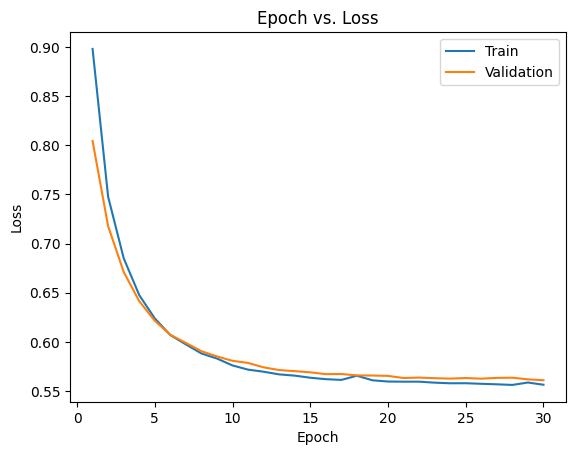

In [32]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

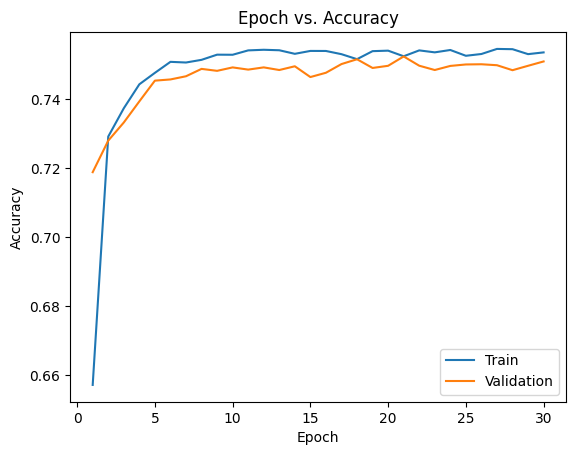

In [33]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

**Making convolutions on tabular data does not make much sense for several reasons:**

**1. Spatial Structure**: Convolutional Neural Networks (CNNs) are designed to exploit the spatial structure in data. In tasks like image classification, the spatial relationships between neighboring pixels are important for understanding the content of an image. However, tabular data does not possess a spatial structure. Each feature in tabular data is typically independent of its neighboring features, and there is no inherent spatial arrangement or order that carries relevant information. Applying convolutions to tabular data would not capture meaningful patterns or relationships.

**2. Feature Invariance**: CNNs are designed to be invariant to certain transformations like translations, rotations, and scaling. In image classification, for example, the location or position of an object within an image should not affect the classification outcome. However, in tabular data, the order or position of features may be crucial. For instance, in time series data, the temporal ordering of events is critical for understanding and predicting future outcomes. Convolutional layers are not well-suited to capture these order-sensitive patterns in tabular data.

**3. Complex Feature Interactions**: Tabular data often contains high-dimensional features with complex interactions. CNNs are effective at capturing local interactions within a receptive field, but they may not be as effective at modeling complex global interactions among features. Multi-Layer Perceptrons (MLPs) with fully connected layers provide greater flexibility in capturing these complex interactions, as every neuron in one layer is connected to every neuron in the subsequent layer. This allows MLPs to better capture the intricate relationships between features in tabular data.

Given these reasons, MLPs are commonly used for processing tabular data. MLPs are capable of handling high-dimensional feature spaces, capturing complex feature interactions, and accommodating the absence of spatial structure in tabular data.


In [34]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        #self.fc1 = nn.Linear(input_dim, 2)
        #self.fc2 = nn.Linear(2, output_dim)
        #self.relu=nn.ReLU()
        #self.flat = nn.Flatten()
        self.network = nn.Sequential(
             # TODO : define 3 linear layer with sizes
             # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
             nn.Linear(input_dim, 2),
             nn.ReLU(),
             nn.Linear(2, output_dim),
             nn.ReLU()
         )

    def forward(self, x):
        """ Defines the computation performed at every call. """
        return self.network(x)

In [35]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005
lr=0.001
mlp_model = TabularNetwork(input_dim,output_dim).to(device)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay =0.0005)
loss_mlp = nn.CrossEntropyLoss()

In [36]:
## TODO : Train model
num_epochs = 50
(train_losses_mlp,val_losses_mlp,train_accs_mlp, val_accs_mlp) = run_training(mlp_model, optimizer_mlp, loss_mlp, device, num_epochs, train_loader, test_loader)

Validation Epoch 50: 100%|██████████| 76/76 [00:00<00:00, 206.62batch/s]


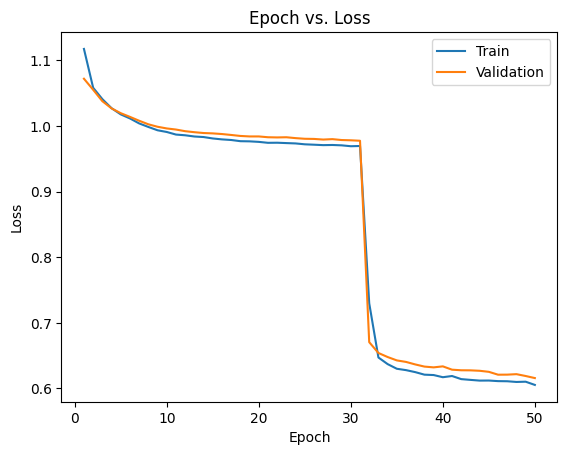

In [37]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses_mlp, val_losses_mlp)

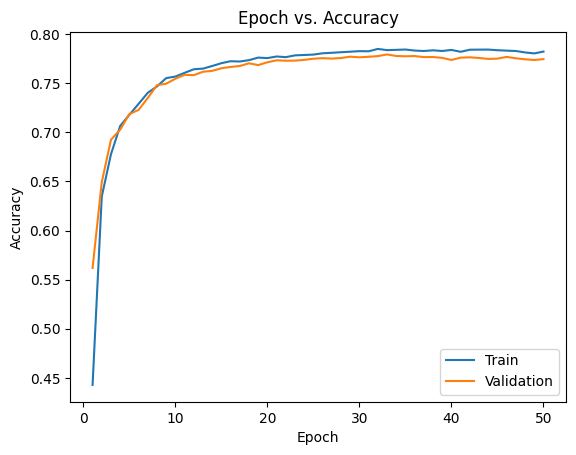

In [38]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_mlp, val_accs_mlp)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?
Our implementation shows that the Multilayer Perceptron (MLP) outperforms the GradientBoostingClassifier. Generally, MLP models tend to perform better than Gradient Boosting Classifiers when dealing with tabular data. This is because MLPs have the flexibility to capture non-linear relationships, handle both continuous and categorical features, effectively handle imbalanced datasets, and learn directly from the data without extensive feature engineering. MLPs excel in capturing intricate patterns and interactions within tabular data, making them a powerful approach for modeling such datasets. However, it's important to note that the performance of specific models relies on the dataset's characteristics, feature quality, and thorough evaluation and experimentation.

## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/